<a href="https://colab.research.google.com/github/Naheemashaik/AIAC/blob/main/NLP_2403A52059_assignment_4_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/arxiv_abstracts.csv')

# Filter for 'cs' category using the correct column name 'category'
filtered_df = df[df['category'].str.contains('cs', na=False)].copy()

# Display the first 5 rows of the filtered DataFrame
print("First 5 rows of the filtered DataFrame (cs category):")
print(filtered_df.head())

# Display column information
print("\nDataFrame Info:")
filtered_df.info()

First 5 rows of the filtered DataFrame (cs category):
  category                                           abstract
0    cs.AI  This paper proposes a novel machine learning a...
1    cs.AI  We study deep learning techniques for natural ...
2    cs.AI  The research focuses on artificial intelligenc...
3    cs.AI  This work presents a neural network model for ...
4    cs.AI  An efficient algorithm for large scale machine...

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5 non-null      object
 1   abstract  5 non-null      object
dtypes: object(2)
memory usage: 212.0+ bytes


In [3]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[\W_]+', ' ', text)  # Remove punctuation and replace with space
    words = text.split()
    # Remove stopwords and join back
    text = ' '.join([word for word in words if word not in stop_words])
    return text

# Apply the cleaning function to the 'abstract' column
filtered_df['cleaned_abstract'] = filtered_df['abstract'].apply(clean_text)

# Display the first few rows with the new cleaned_abstract column
print("First 5 rows of filtered_df with 'cleaned_abstract':")
print(filtered_df[['abstract', 'cleaned_abstract']].head())

First 5 rows of filtered_df with 'cleaned_abstract':
                                            abstract  \
0  This paper proposes a novel machine learning a...   
1  We study deep learning techniques for natural ...   
2  The research focuses on artificial intelligenc...   
3  This work presents a neural network model for ...   
4  An efficient algorithm for large scale machine...   

                                    cleaned_abstract  
0  paper proposes novel machine learning approach...  
1  study deep learning techniques natural languag...  
2  research focuses artificial intelligence metho...  
3  work presents neural network model pattern rec...  
4  efficient algorithm large scale machine learni...  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limiting to 1000 features for manageable size

# Fit and transform the cleaned abstracts
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['cleaned_abstract'])

# Get feature names (terms)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Display the shape of the TF-IDF matrix
print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")
print(f"Number of unique terms (features): {len(feature_names)}")

Shape of TF-IDF matrix: (5, 34)
Number of unique terms (features): 34


In [5]:
import pandas as pd

# Calculate the sum of TF-IDF scores for each term across all documents
# tfidf_matrix is a sparse matrix, so we sum along axis 0 to get overall scores for each feature
overall_tfidf_scores = tfidf_matrix.sum(axis=0)

# Convert to a dense array and create a pandas Series for easier manipulation
overall_tfidf_scores_array = overall_tfidf_scores.A.flatten()
terms_df = pd.DataFrame({'term': feature_names, 'tfidf_score': overall_tfidf_scores_array})

# Sort the terms by their TF-IDF scores in descending order
top_terms = terms_df.sort_values(by='tfidf_score', ascending=False)

# Display the top 20 terms and their scores
print("\nTop 20 terms across the corpus based on overall TF-IDF scores:")
print(top_terms.head(20))


Top 20 terms across the corpus based on overall TF-IDF scores:
            term  tfidf_score
14      learning     0.767907
15       machine     0.629473
13         large     0.404907
0      algorithm     0.404907
8      efficient     0.404907
7      discussed     0.404907
29         scale     0.404907
1       analysis     0.377964
3     artificial     0.377964
9        focuses     0.377964
16       methods     0.377964
17         model     0.377964
11  intelligence     0.377964
33          work     0.377964
20        neural     0.377964
24      presents     0.377964
19       network     0.377964
5           data     0.377964
27   recognition     0.377964
28      research     0.377964


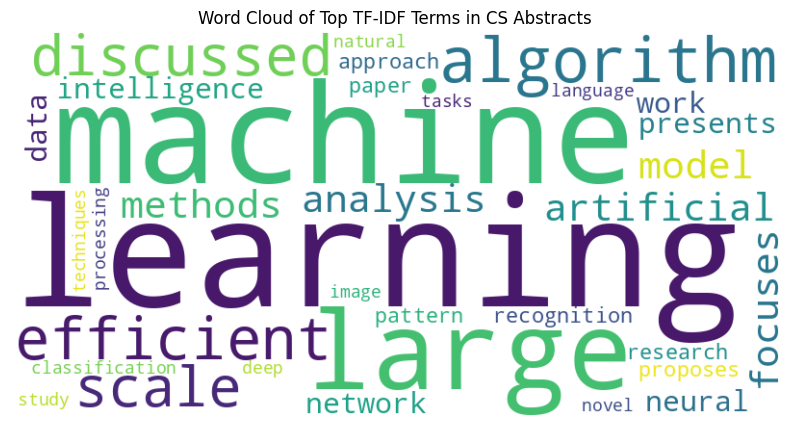

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary of word frequencies from the top_terms DataFrame
# The TF-IDF scores will serve as weights for the word cloud
word_freq = dict(zip(top_terms['term'], top_terms['tfidf_score']))

# Generate a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top TF-IDF Terms in CS Abstracts')
plt.show()


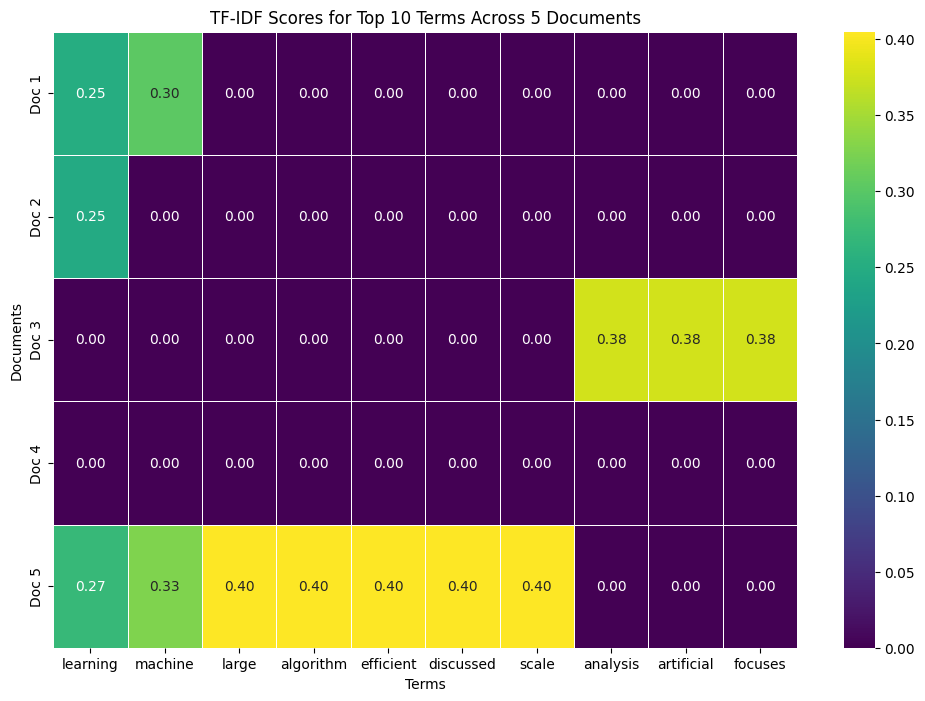

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select the top 10 terms from the sorted list
top_10_terms = top_terms['term'].head(10).tolist()

# Get the indices of these top 10 terms in the original feature_names
# This is necessary to extract their columns from the tfidf_matrix
term_indices = [np.where(feature_names == term)[0][0] for term in top_10_terms]

# Select the TF-IDF scores for the top 10 terms across all 5 documents
# Since filtered_df has only 5 documents, we'll use all of them
selected_tfidf_scores = tfidf_matrix[:, term_indices].toarray()

# Create a DataFrame for the heatmap
# Use document indices as rows and top 10 terms as columns
heatmap_df = pd.DataFrame(selected_tfidf_scores, columns=top_10_terms,
                          index=[f'Doc {i+1}' for i in range(filtered_df.shape[0])])

# Generate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('TF-IDF Scores for Top 10 Terms Across 5 Documents')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.show()


Discussion

In this experiment, TF-IDF (Term Frequency–Inverse Document Frequency) was applied to research paper abstracts from the Computer Science (AI) domain to identify important terms. The text data was first cleaned by removing numbers, punctuation, and stopwords to improve the quality of analysis.

The TF-IDF model successfully highlighted domain-specific terms such as machine learning, neural network, and artificial intelligence, which are highly relevant to the selected research area. Unlike simple word frequency, TF-IDF assigns higher importance to words that are frequent in a document but rare across the corpus, making it more effective for research text analysis.

The word cloud visualization provided an intuitive overview of the most significant terms in the dataset, while the heatmap showed how TF-IDF scores for top terms varied across different documents. This helped in understanding the distribution and relevance of key concepts among multiple abstracts.

Overall, this analysis demonstrates that TF-IDF is an efficient technique for feature extraction in natural language processing tasks such as document comparison, topic identification, and information retrieval. The results can be further improved by using a larger dataset and applying advanced NLP techniques such as n-grams or topic modeling.